In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
import time
import copy
from scipy.signal import find_peaks, resample
from scipy import signal
from icecream import ic
from collections import OrderedDict

from neurolib.models.aln import ALNModel
from neurolib.models.aln import ALNModel_SaveSteps
import neurolib.utils.stimulus as stim
import neurolib.utils.functions as func  
from neurolib.utils.parameterSpace import ParameterSpace
from neurolib.optimize.exploration import BoxSearch
import os
import sys
from pynverse import inversefunc

from intersect import intersection


sys.path.insert(0, '..')
from prc_funcs import *
from functions import *
    

import matplotlib.colors as mcolors

colors = mcolors.TABLEAU_COLORS
by_hsv = sorted((tuple(mcolors.rgb_to_hsv(mcolors.to_rgb(color))),
                         name)
                        for name, color in colors.items())
colrs = [name for hsv, name in by_hsv]

#hide
import logging
logging.getLogger().setLevel(logging.INFO)
import warnings
warnings.filterwarnings("ignore")

BASE_PATH = "../../../../" # need to go back from default hdf path "./data/hdf"
HDF_PATH = BASE_PATH + "Data/"

# **Plot of stepinput, sine and rate input for different amplitudes**

## **1. Calc and get data**
| StepInput | SineInput | RealInput |
| --- | :---: | ---: |
| 0,1 mV/ms x 1ms | 0,005 mV/ms |  Ke = 10 |
| 0,2 mV/ms x 5ms | 0,01 mV/ms | Ke = 20 |
| 0,4 mV/ms x 5ms | 0,04 mV/ms | Ke = 100 |

In [2]:
aln = ALNModel()
aln.params['mue_ext_mean'] = 1.1
aln.params['mui_ext_mean'] = 0.5
aln.params['dt'] = 0.005
aln.params['sampling_dt'] = aln.params.dt
aln.params['a'] = 0.
aln.params['b'] = 0.
aln.params['sigma_ou'] = 0.
prc = PRC_ALN(aln)

INFO:root:aln: Model initialized.
ic| domfreq: 21.52631578947368


initialised ...


In [3]:
#for amp in [0.005, 0.01, 0.04]:
#    prc.calc_prc_xcorr(
#            itype="current",
#            stim_type="sine",
#            amplitude=amp,
#            num_points=300
#        )
#    np.save('data/PRC_sine_{0:.3f}mV.npy'.format(amp), prc.prc_xcorr) 

In [4]:
#prc.calc_prc_xcorr(
#        itype="current",
#        amplitude=0.1,
#        stim_len=1,
#        num_points=300
#)
#np.save('data/PRC_0,1mV1ms.npy', prc.prc_xcorr) 

In [5]:
#prc.calc_prc_xcorr(
#        itype="current",
#        stim_type="sine",
#        amplitude=0.005,
#        num_points=300
#    )
#np.save('data/PRC_sine_0.005mV.npy', prc.prc_xcorr) 

In [3]:
tst = prc.frcycle
frcycleT = np.hstack([tst[int(len(tst)/2):], tst[:int(len(tst)/2)]])

In [4]:
prc_1x1 = np.load('data/PRC_0,1mV1ms.npy',allow_pickle='TRUE').item()
prc_2x5 = np.load('data/PRC_0,2mV5ms.npy',allow_pickle='TRUE').item()
prc_4x5 = np.load('data/PRC_0,4mV5ms.npy',allow_pickle='TRUE').item()

prc_s005 = np.load('data/PRC_sine_0.005mV.npy',allow_pickle='TRUE').item()
prc_s01 = np.load('data/PRC_sine_0.010mV.npy',allow_pickle='TRUE').item()
prc_s04 = np.load('data/PRC_sine_0.040mV.npy',allow_pickle='TRUE').item()

prc_r10 = np.load('data/PRC_real_Kegl=10.npy',allow_pickle='TRUE').item()
prc_r20 = np.load('data/PRC_real_Kegl=20.npy',allow_pickle='TRUE').item()
prc_r100 = np.load('data/PRC_real_Kegl=100.npy',allow_pickle='TRUE').item()

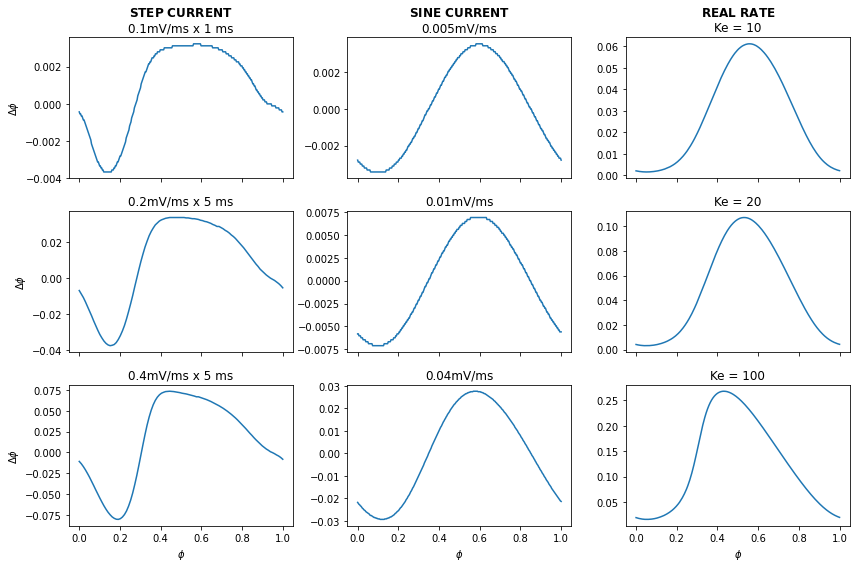

In [5]:
cols = ['Column {}'.format(col) for col in range(1, 4)]
rows = ['Row {}'.format(row) for row in ['A', 'B', 'C', 'D']]

fig, axes = plt.subplots(nrows=3, ncols=3, figsize=(12, 8), sharex=True)


#axes[0, 0].annotate("STEP CURRENT", xy=(0.5, 0.5), xycoords="data",
#                      xytext=(0, 0),
#                      va="top", ha="center", fontsize=15)
#axes[0, 1].annotate("SINE CURRENT", xy=(0.5, 0.5), xycoords="data",
#                      xytext=(0.5,1.25),
#                      va="top", ha="center", fontsize=15)
#axes[0, 2].annotate("REAL RATE", xy=(0.5, 0.5), xycoords="data",
#                      xytext=(0.5, 3.75),
#                      va="top", ha="center", fontsize=15)
axes[0, 0].set_title(r'$\bf{STEP \ CURRENT}$'+'\n'+'0.1mV/ms x 1 ms')
axes[1, 0].set_title("0.2mV/ms x 5 ms")
axes[2, 0].set_title("0.4mV/ms x 5 ms")

axes[0, 1].set_title(r'$\bf{SINE \ CURRENT}$'+'\n'+"0.005mV/ms")
axes[1, 1].set_title("0.01mV/ms")
axes[2, 1].set_title("0.04mV/ms")

axes[0, 2].set_title(r'$\bf{REAL \ RATE}$'+'\n'+ "Ke = 10")
axes[1, 2].set_title("Ke = 20")
axes[2, 2].set_title("Ke = 100")

axes[2, 0].set_xlabel(r"$\phi$")
axes[2, 1].set_xlabel(r"$\phi$")
axes[2, 2].set_xlabel(r"$\phi$")

axes[0, 0].set_ylabel(r"$\Delta \phi$")
axes[1, 0].set_ylabel(r"$\Delta \phi$")
axes[2, 0].set_ylabel(r"$\Delta \phi$")

p1x1 = np.asarray(list(prc_1x1.values())) / prc.frperiod
axes[0, 0].plot(np.linspace(0, 1, len(p1x1)), p1x1)
p2x5 = np.asarray(list(prc_2x5.values())) / prc.frperiod
axes[1, 0].plot(np.linspace(0, 1, len(p2x5)), p2x5)
p4x5 = np.asarray(list(prc_4x5.values())) / prc.frperiod
axes[2, 0].plot(np.linspace(0, 1, len(p4x5)), p4x5)

ps005 = np.asarray(list(prc_s005.values())) / prc.frperiod
axes[0, 1].plot(np.linspace(0, 1, len(ps005)), ps005)
ps01 = np.asarray(list(prc_s01.values())) / prc.frperiod
axes[1, 1].plot(np.linspace(0, 1, len(ps01)), ps01)
ps04 = np.asarray(list(prc_s04.values())) / prc.frperiod
axes[2, 1].plot(np.linspace(0, 1, len(ps04)), ps04)

pr10 = np.asarray(list(prc_r10.values())) / prc.frperiod
axes[0, 2].plot(np.linspace(0, 1, len(pr10)), pr10)
pr20 = np.asarray(list(prc_r20.values())) / prc.frperiod
axes[1, 2].plot(np.linspace(0, 1, len(pr20)), pr20)
pr100 = np.asarray(list(prc_r100.values())) / prc.frperiod
axes[2, 2].plot(np.linspace(0, 1, len(pr100)), pr100)

fig.tight_layout()
plt.show()

## now with my style

ic| max(lab): 0.002
ic| max(lab): 0.002
ic| max(lab): 0.06
ic| max(lab): 0.02
ic| max(lab): 0.005
ic| max(lab): 0.1
ic| max(lab): 0.05
ic| max(lab): 0.02
ic| max(lab): 0.2


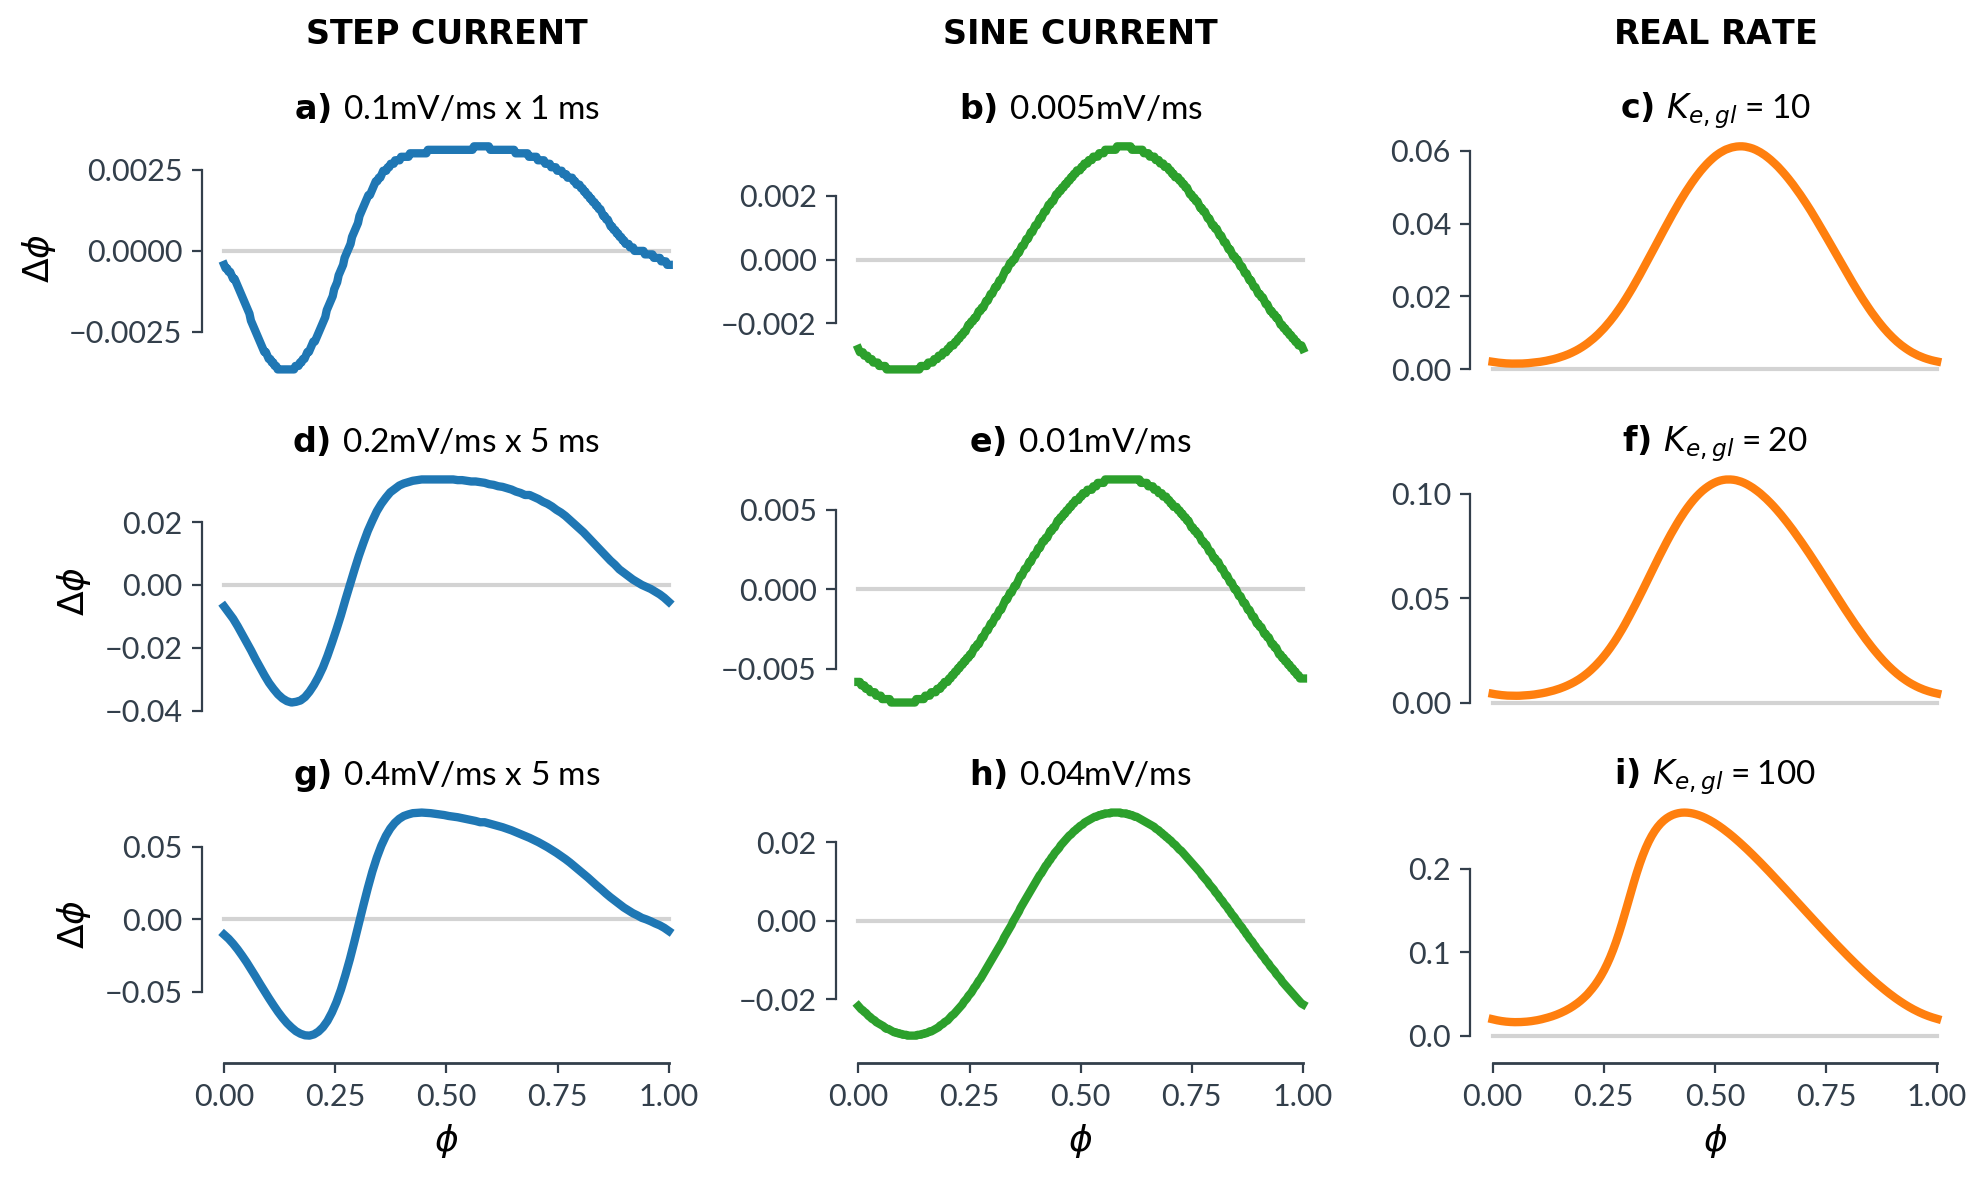

In [12]:
plt.rcParams['font.family'] = 'sans-serif'
plt.rcParams['font.sans-serif'] = 'Lato'
plt.rcParams['axes.edgecolor']='#333F4B'
plt.rcParams['axes.linewidth']=0.8
plt.rcParams['xtick.color']='#333F4B'
plt.rcParams['ytick.color']='#333F4B'
plt.rcParams['axes.labelsize']=13
plt.rcParams['xtick.labelsize']=11
plt.rcParams['ytick.labelsize']=11

fig, axes = plt.subplots(nrows=3, ncols=3, figsize=(10, 6), dpi=200, sharex=True)


#axes[0, 0].annotate("STEP CURRENT", xy=(0.5, 0.5), xycoords="data",
#                      xytext=(0, 0),
#                      va="top", ha="center", fontsize=15)
#axes[0, 1].annotate("SINE CURRENT", xy=(0.5, 0.5), xycoords="data",
#                      xytext=(0.5,1.25),
#                      va="top", ha="center", fontsize=15)
#axes[0, 2].annotate("REAL RATE", xy=(0.5, 0.5), xycoords="data",
#                      xytext=(0.5, 3.75),
#                      va="top", ha="center", fontsize=15)
axes[0, 0].set_title(r'$\bf{STEP \ CURRENT}$'+'\n\n'+r'$\bf{a)}\ $0.1mV/ms x 1 ms')
axes[1, 0].set_title(r"$\bf{d)}\ $0.2mV/ms x 5 ms")
axes[2, 0].set_title(r"$\bf{g)}\ $0.4mV/ms x 5 ms")

axes[0, 1].set_title(r'$\bf{SINE \ CURRENT}$'+'\n\n'+r'$\bf{b)}\ $0.005mV/ms')
axes[1, 1].set_title(r"$\bf{e)}\ $0.01mV/ms")
axes[2, 1].set_title(r"$\bf{h)}\ $0.04mV/ms")

axes[0, 2].set_title(r'$\bf{REAL \ RATE}$'+'\n\n'+ r'$\bf{c)}\ $$K_{e,gl}$ = 10')
axes[1, 2].set_title(r"$\bf{f)}\ $$K_{e,gl}$ = 20")
axes[2, 2].set_title(r"$\bf{i)}\ $$K_{e,gl}$ = 100")

axes[2, 0].set_xlabel(r"$\phi$")
axes[2, 1].set_xlabel(r"$\phi$")
axes[2, 2].set_xlabel(r"$\phi$")

axes[0, 0].set_ylabel(r"$\Delta \phi$")
axes[1, 0].set_ylabel(r"$\Delta \phi$")
axes[2, 0].set_ylabel(r"$\Delta \phi$")

p1x1 = np.asarray(list(prc_1x1.values())) / prc.frperiod
axes[0, 0].plot(np.linspace(0, 1, len(p1x1)), p1x1, lw=3)
p2x5 = np.asarray(list(prc_2x5.values())) / prc.frperiod
axes[1, 0].plot(np.linspace(0, 1, len(p2x5)), p2x5, lw=3)
p4x5 = np.asarray(list(prc_4x5.values())) / prc.frperiod
axes[2, 0].plot(np.linspace(0, 1, len(p4x5)), p4x5, lw=3)

ps005 = np.asarray(list(prc_s005.values())) / prc.frperiod
axes[0, 1].plot(np.linspace(0, 1, len(ps005)), ps005, lw=3, c="tab:green")
ps01 = np.asarray(list(prc_s01.values())) / prc.frperiod
axes[1, 1].plot(np.linspace(0, 1, len(ps01)), ps01, lw=3, c="tab:green")
ps04 = np.asarray(list(prc_s04.values())) / prc.frperiod
axes[2, 1].plot(np.linspace(0, 1, len(ps04)), ps04, lw=3, c="tab:green")

pr10 = np.asarray(list(prc_r10.values())) / prc.frperiod
axes[0, 2].plot(np.linspace(0, 1, len(pr10)), pr10, lw=3, c="tab:orange")
pr20 = np.asarray(list(prc_r20.values())) / prc.frperiod
axes[1, 2].plot(np.linspace(0, 1, len(pr20)), pr20, lw=3, c="tab:orange")
pr100 = np.asarray(list(prc_r100.values())) / prc.frperiod
axes[2, 2].plot(np.linspace(0, 1, len(pr100)), pr100, lw=3, c="tab:orange")

for ax in fig.get_axes():
    if not ax.get_subplotspec().is_last_row():
        ax.spines["bottom"].set_visible(False)
        ax.tick_params(bottom=False)
    ax.plot((0, 1), (0, 0), color="lightgrey", zorder=1)
    ax.tick_params(right=False, top=False)
    ax.spines["top"].set_visible(False), ax.spines["right"].set_visible(False)
    ax.spines["bottom"].set_bounds(low=0, high=1)
    plt.draw()
    lab = [float(item.get_text().replace("−", "-")) for item in ax.get_yticklabels(which='both')][1:-1]
    ic(max(lab))
    ax.spines["left"].set_bounds(low=min(lab), high=max(lab))
    for line in ["bottom"]:
        ax.spines[line].set_linewidth(1)
        ax.spines[line].set_position(("outward",6))
    
            
# manually adjust...
axes[2, 2].spines["left"].set_bounds(low=0, high=0.2)
axes[2, 2].set_yticks([0, 0.1, 0.2])
axes[2, 2].set_yticklabels(labels=['0.0', '0.1', '0.2'] )

axes[0, 0].spines["left"].set_bounds(low=-0.0025, high=0.0025)
axes[0, 0].set_yticks([-0.0025, 0, 0.0025])
#axes[2, 2].set_yticklabels(labels=['0.0', '0.1', '0.2'] )

fig.tight_layout()
fig.savefig("Pics/PRC_Overview_2.pdf")

# Rather a Pic of ony one PRC per type. iPRc, Sine-prc, real rate..

### get iPRC

In [10]:
def lambda_factory(ab):
    return lambda x:x*ab[0]+ab[1]

def broken_line(x, x0, y0):
    cl = []
    fl = []
    for i in range(len(x0)-1):
        ab = np.polyfit(x0[i:i+2], y0[i:i+2], 1)
        #ic(ab)
        # Compute and append a "condition" interval
        cl.append(np.logical_and(x >= x0[i], x <= x0[i+1]))
        # Create a line function for the interval
        fl.append(lambda_factory(ab))
    return(np.piecewise(x, condlist=cl, funclist=fl))


def f1(x):
    return broken_line(x, x1, y1)

def f2(x):
    return broken_line(x, x2[::-1], y2[::-1])

def f(xy):
    x, y = xy
    z = np.array([y - f1(x), y - f2(x)])
    return z

In [11]:
sampling = 1
aln = ALNModel()
aln.params['mue_ext_mean'] = 1.1
aln.params['mui_ext_mean'] = 0.5
aln.params['dt'] = 0.01
aln.params['sampling_dt'] = aln.params.dt * sampling
aln.params['a'] = 0.
aln.params['b'] = 0.
aln.params['sigma_ou'] = 0.
#aln.params['Ke_gl'] = 30.
prc = PRC_ALN(aln)

INFO:root:aln: Model initialized.
ic| domfreq: 21.50526315789473


initialised ...


In [12]:
#np.save('data/PRC_1mV0,1ms.npy', prc.prc_xcorr) 
prc_xcorr = np.load('data/PRC_1mV0,1ms.npy',allow_pickle='TRUE').item()

In [13]:
period_fr = prc.frperiod
phis = np.asarray(list(prc_xcorr.keys()))
prcs = np.asarray(list(prc_xcorr.values()))

# Have a data point for phi=0 and phi=T
phis = np.concatenate(([0.], phis))
phis = np.concatenate((phis, [period_fr]))
prcs = np.concatenate(([prcs[0]], prcs))
prcs = np.concatenate((prcs, [prcs[-1]]))
def prc_func(x):
    return broken_line(x, phis, prcs) 

In [14]:
def iPRC_func(phi):
    return prc_func(phi) / (2*10**(-14)*prc.frperiod) 

## convolve with sine

In [15]:
xs = np.linspace(0, prc.frperiod, int(prc.frperiod*10))
sig = iPRC_func(xs)
#win = np.sin(np.linspace(0, 2*np.pi, len(xs)))*2*10**(-14) * 0.01 
win = np.sin(np.linspace(-1.5*np.pi, 0.5*np.pi, len(xs)))*2*10**(-14) * 0.01
win2 = np.concatenate([win, win])
sine_prc = signal.convolve(sig, win2, mode='same') 


## get real rate PRC Kegl=50

In [16]:
prc_rate = np.load('data/PRC_real_Kegl=50_highres.npy',allow_pickle='TRUE').item()

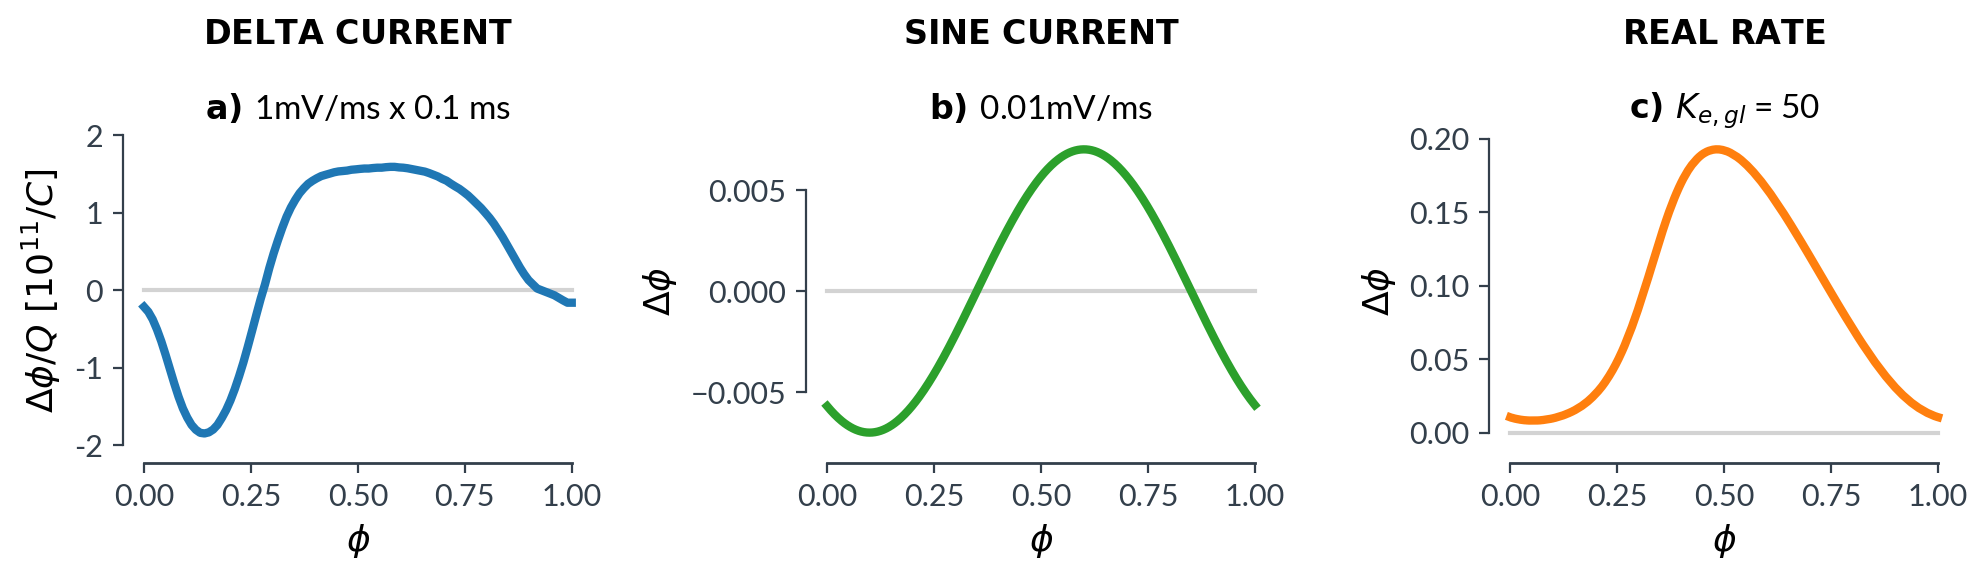

In [17]:
plt.rcParams['font.family'] = 'sans-serif'
plt.rcParams['font.sans-serif'] = 'Lato'
plt.rcParams['axes.edgecolor']='#333F4B'
plt.rcParams['axes.linewidth']=0.8
plt.rcParams['xtick.color']='#333F4B'
plt.rcParams['ytick.color']='#333F4B'
plt.rcParams['axes.labelsize']=13
plt.rcParams['xtick.labelsize']=11
plt.rcParams['ytick.labelsize']=11

fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(10, 3), dpi=200, sharex=True)


#axes[0, 0].annotate("STEP CURRENT", xy=(0.5, 0.5), xycoords="data",
#                      xytext=(0, 0),
#                      va="top", ha="center", fontsize=15)
#axes[0, 1].annotate("SINE CURRENT", xy=(0.5, 0.5), xycoords="data",
#                      xytext=(0.5,1.25),
#                      va="top", ha="center", fontsize=15)
#axes[0, 2].annotate("REAL RATE", xy=(0.5, 0.5), xycoords="data",
#                      xytext=(0.5, 3.75),
#                      va="top", ha="center", fontsize=15)
axes[0].set_title(r'$\bf{DELTA \ CURRENT}$'+'\n\n'+r"$\bf{a)}\ $1mV/ms x 0.1 ms")

axes[1].set_title(r'$\bf{SINE \ CURRENT}$'+'\n\n'+r"$\bf{b)}\ $0.01mV/ms")

axes[2].set_title(r'$\bf{REAL \ RATE}$'+'\n\n'+ r"$\bf{c)}\ $$K_{e,gl}$ = 50")


axes[0].set_xlabel(r"$\phi$")
axes[1].set_xlabel(r"$\phi$")
axes[2].set_xlabel(r"$\phi$")

axes[0].set_ylabel(r"$\Delta \phi/Q\ [10^{11}/C]$")
axes[1].set_ylabel(r"$\Delta \phi$")
axes[2].set_ylabel(r"$\Delta \phi$")

xs = np.linspace(0, 1, 100)
axes[0].plot(xs, iPRC_func(xs*prc.frperiod) / 1e11, lw=3, c="tab:blue")

xs = np.linspace(0, 1, len(sine_prc))
axes[1].plot(xs, sine_prc, lw=3, c="tab:green")

prate = np.asarray(list(prc_rate.values())) / prc.frperiod
axes[2].plot(np.linspace(0, 1, len(prate)), prate, lw=3, c="tab:orange")


for ax in fig.get_axes():
    if not ax.get_subplotspec().is_last_row():
        ax.spines["bottom"].set_visible(False)
        ax.tick_params(bottom=False)
    ax.plot((0, 1), (0, 0), color="lightgrey", zorder=1)
    ax.tick_params(right=False, top=False)
    ax.spines["top"].set_visible(False), ax.spines["right"].set_visible(False)
    ax.spines["bottom"].set_bounds(low=0, high=1)
    plt.draw()
    lab = [float(item.get_text().replace("−", "-")) for item in ax.get_yticklabels(which='both')][1:-1]
    #ic(float(lab[0].replace("−", "-")))
    ax.spines["left"].set_bounds(low=min(lab), high=max(lab))
    for line in ["bottom"]:
        ax.spines[line].set_linewidth(1)
        ax.spines[line].set_position(("outward",6))

# manually adjust...
axes[0].spines["left"].set_bounds(low=-2, high=2)
axes[0].set_yticks([-2, -1, 0, 1, 2])
axes[0].set_yticklabels(labels=['-2', '-1', '0', '1', '2'] )
axes[1].spines["left"].set_bounds(low=-0.005, high=0.005)


fig.tight_layout()
#fig.savefig("Pics/PRC_small_Overview_2.pdf")

# **PRC Rapid Decay deviation for same parameters**

In [18]:
aln = ALNModel()
aln.params['mue_ext_mean'] = 1.1
aln.params['mui_ext_mean'] = 0.5
aln.params['dt'] = 0.01
aln.params['sampling_dt'] = aln.params.dt
aln.params['a'] = 0.
aln.params['b'] = 0.
aln.params['sigma_ou'] = 0.
prc = PRC_ALN(aln)
prc_t = PRC_ALN_testing(aln)

tst = prc.frcycle
frcycleT = np.hstack([tst[int(len(tst)/2):], tst[:int(len(tst)/2)]])


INFO:root:aln: Model initialized.
ic| domfreq: 21.50526315789473


initialised ...
initialised ...


## 1. Step Input

In [19]:
#prc_t.test_rapid_decay("current", 
#           amplitude=0.1, 
#           stim_len=1, 
#           num_points=100)

#np.save('data/RapidDecay_0,1mV1ms.npy', prc_t.amp_diffs) 

In [20]:
#prc_t.test_rapid_decay("current", 
#           amplitude=0.2, 
#           stim_len=5, 
#           num_points=100)

#np.save('data/RapidDecay_0,2mV5ms.npy', prc_t.amp_diffs) 

In [21]:
#prc_t.test_rapid_decay("current", 
#           amplitude=0.4, 
#           stim_len=5, 
#           num_points=100)

#np.save('data/RapidDecay_0,4mV5ms.npy', prc_t.amp_diffs) 

## 2. Sine Input

In [22]:
#for amp in [0.005, 0.01, 0.04]:
#    prc_t.test_rapid_decay(
#            itype="current",
#            stim_type="sine",
#            amplitude=amp,
#            num_points=100
#        )
#    np.save('data/RapidDecay_sine_{0:.3f}mV.npy'.format(amp), prc_t.amp_diffs) 

In [23]:
#for Ke in [10, 20, 100]:
#    prc_t.test_rapid_decay(
#            itype="real",
#            Ke_gl=Ke,
#            num_points=100
#        )
#    np.save('data/RapidDecay_real_Kegl={0:.0f}.npy'.format(Ke), prc_t.amp_diffs)

In [24]:
rd_1x1 = np.load('data/RapidDecay_0,1mV1ms.npy',allow_pickle='TRUE').item()
rd_2x5 = np.load('data/RapidDecay_0,2mV5ms.npy',allow_pickle='TRUE').item()
rd_4x5 = np.load('data/RapidDecay_0,4mV5ms.npy',allow_pickle='TRUE').item()

rd_s005 = np.load('data/RapidDecay_sine_0.005mV.npy',allow_pickle='TRUE').item()
rd_s01 = np.load('data/RapidDecay_sine_0.010mV.npy',allow_pickle='TRUE').item()
rd_s04 = np.load('data/RapidDecay_sine_0.040mV.npy',allow_pickle='TRUE').item()

rd_r10 = np.load('data/RapidDecay_real_Kegl=10.npy',allow_pickle='TRUE').item()
rd_r20 = np.load('data/RapidDecay_real_Kegl=20.npy',allow_pickle='TRUE').item()
rd_r100 = np.load('data/RapidDecay_real_Kegl=100.npy',allow_pickle='TRUE').item()

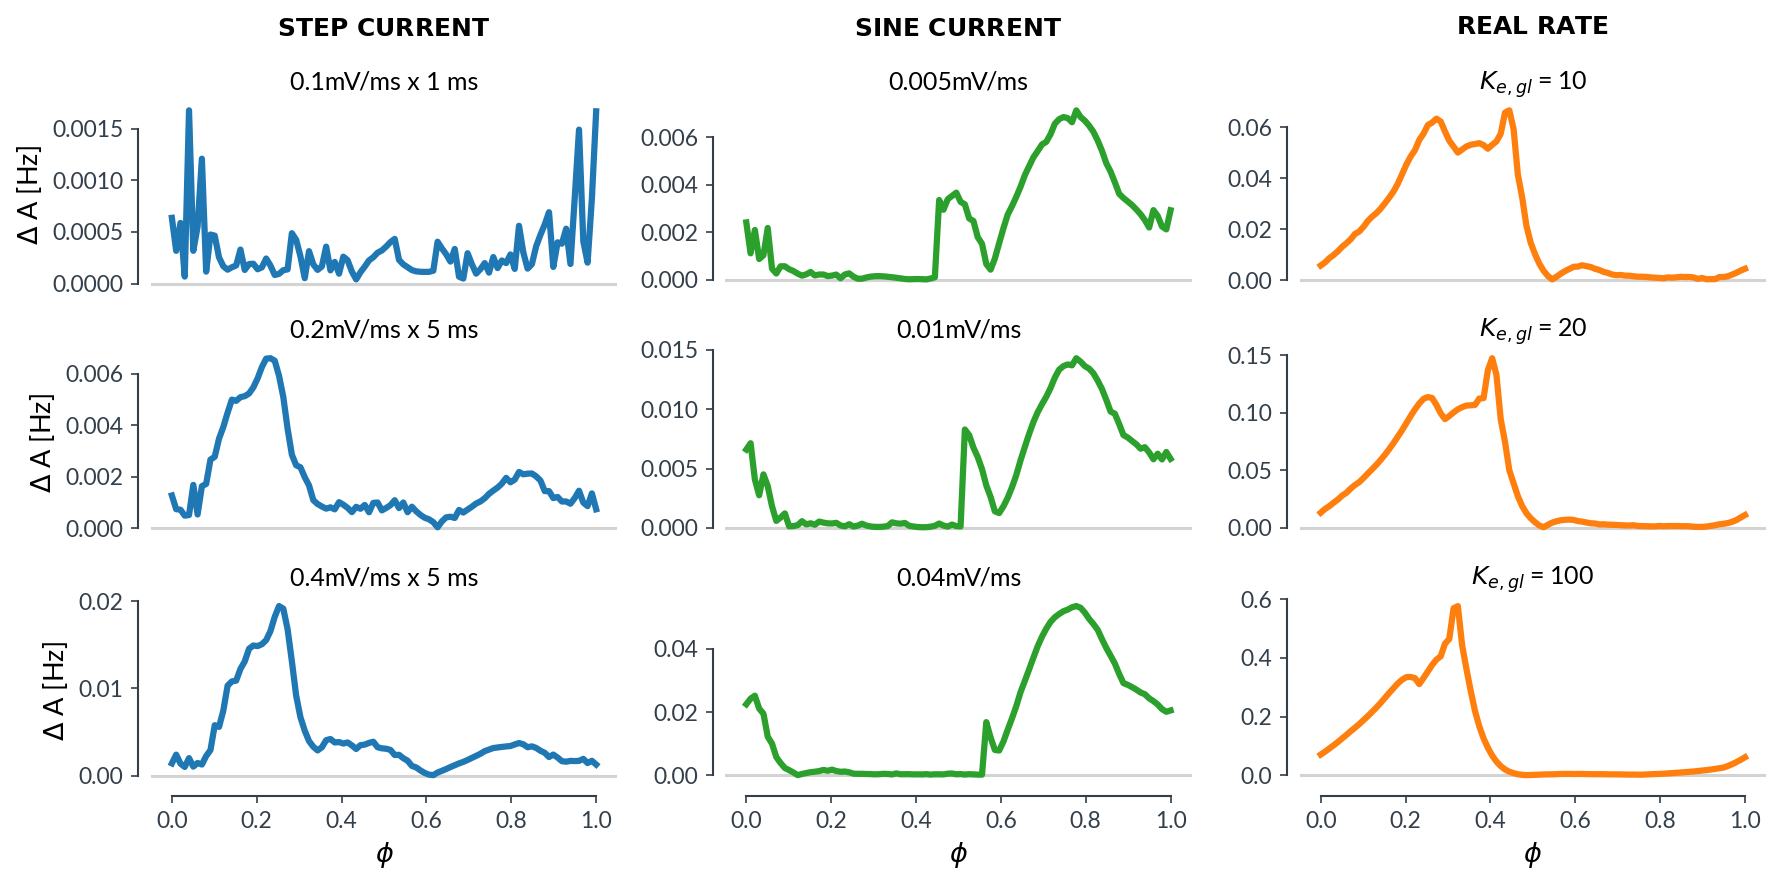

In [25]:
plt.rcParams['font.family'] = 'sans-serif'
plt.rcParams['font.sans-serif'] = 'Lato'
plt.rcParams['axes.edgecolor']='#333F4B'
plt.rcParams['axes.linewidth']=0.8
plt.rcParams['xtick.color']='#333F4B'
plt.rcParams['ytick.color']='#333F4B'
plt.rcParams['axes.labelsize']=13
fig, axes = plt.subplots(nrows=3, ncols=3, figsize=(12, 6), dpi=150, sharex=True)


#axes[0, 0].annotate("STEP CURRENT", xy=(0.5, 0.5), xycoords="data",
#                      xytext=(0, 0),
#                      va="top", ha="center", fontsize=15)
#axes[0, 1].annotate("SINE CURRENT", xy=(0.5, 0.5), xycoords="data",
#                      xytext=(0.5,1.25),
#                      va="top", ha="center", fontsize=15)
#axes[0, 2].annotate("REAL RATE", xy=(0.5, 0.5), xycoords="data",
#                      xytext=(0.5, 3.75),
#                      va="top", ha="center", fontsize=15)
axes[0, 0].set_title(r'$\bf{STEP \ CURRENT}$'+'\n\n'+'0.1mV/ms x 1 ms')
axes[1, 0].set_title("0.2mV/ms x 5 ms")
axes[2, 0].set_title("0.4mV/ms x 5 ms")

axes[0, 1].set_title(r'$\bf{SINE \ CURRENT}$'+'\n\n'+"0.005mV/ms")
axes[1, 1].set_title("0.01mV/ms")
axes[2, 1].set_title("0.04mV/ms")

axes[0, 2].set_title(r'$\bf{REAL \ RATE}$'+'\n\n'+ r"$K_{e,gl}$ = 10")
axes[1, 2].set_title(r"$K_{e,gl}$ = 20")
axes[2, 2].set_title(r"$K_{e,gl}$ = 100")

axes[2, 0].set_xlabel(r"$\phi$")
axes[2, 1].set_xlabel(r"$\phi$")
axes[2, 2].set_xlabel(r"$\phi$")

axes[0, 0].set_ylabel(r"$\Delta$ A [Hz]")
axes[1, 0].set_ylabel(r"$\Delta$ A [Hz]")
axes[2, 0].set_ylabel(r"$\Delta$ A [Hz]")

r1x1 = np.asarray(list(rd_1x1.values())) 
axes[0, 0].plot(np.linspace(0, 1, len(r1x1)), r1x1, lw=3)
r2x5 = np.asarray(list(rd_2x5.values())) 
axes[1, 0].plot(np.linspace(0, 1, len(r2x5)), r2x5, lw=3)
r4x5 = np.asarray(list(rd_4x5.values())) 
axes[2, 0].plot(np.linspace(0, 1, len(r4x5)), r4x5, lw=3)

rs005 = np.asarray(list(rd_s005.values())) 
axes[0, 1].plot(np.linspace(0, 1, len(rs005)), rs005, lw=3, c="tab:green")
rs01 = np.asarray(list(rd_s01.values())) 
axes[1, 1].plot(np.linspace(0, 1, len(rs01)), rs01, lw=3, c="tab:green")
rs04 = np.asarray(list(rd_s04.values())) 
axes[2, 1].plot(np.linspace(0, 1, len(rs04)), rs04, lw=3, c="tab:green")

pr10 = np.asarray(list(rd_r10.values())) 
axes[0, 2].plot(np.linspace(0, 1, len(pr10)), pr10, lw=3, c="tab:orange")
pr20 = np.asarray(list(rd_r20.values())) 
axes[1, 2].plot(np.linspace(0, 1, len(pr20)), pr20, lw=3, c="tab:orange")
pr100 = np.asarray(list(rd_r100.values())) 
axes[2, 2].plot(np.linspace(0, 1, len(pr100)), pr100, lw=3, c="tab:orange")

for ax in fig.get_axes():
    if not ax.get_subplotspec().is_last_row():
        ax.spines["bottom"].set_visible(False)
        ax.tick_params(bottom=False)
    ax.axhline(0, xmin=0, xmax=1, color="lightgrey", zorder=1)
    ax.tick_params(right=False, top=False)
    ax.spines["top"].set_visible(False), ax.spines["right"].set_visible(False)
    ax.spines["bottom"].set_bounds(low=0, high=1)
    plt.draw()
    lab = [float(item.get_text().replace("−", "-")) for item in ax.get_yticklabels(which='both')][1:-1]
    #ic(float(lab[0].replace("−", "-")))
    ax.spines["left"].set_bounds(low=min(lab), high=max(lab))
    for line in ["left","bottom"]:
        ax.spines[line].set_linewidth(1)
        ax.spines[line].set_position(("outward",6))

# manually adjust...
#axes[2, 2].spines["left"].set_bounds(low=0, high=0.2)
#axes[2, 2].set_yticks([0, 0.1, 0.2])
#axes[2, 2].set_yticklabels(labels=['0.0', '0.1', '0.2'] )

fig.tight_layout()
#fig.savefig("Pics/Rapid_Decay_Overview.pdf")

# **Redo Rapid Decay Analysis with new "holistic" method**

## 1. Step 1mV/ms x 0.1 ms (Delta)

In [26]:
aln = ALNModel_SaveSteps()
aln.params['mue_ext_mean'] = 1.1
aln.params['mui_ext_mean'] = 0.5
aln.params['dt'] = 0.01
aln.params['sampling_dt'] = aln.params.dt
aln.params['a'] = 0.
aln.params['b'] = 0.
aln.params['sigma_ou'] = 0.
prc = PRC_ALN(aln)
prc_t = PRC_ALN_testing(aln)

tst = prc.frcycle
frcycleT = np.hstack([tst[int(len(tst)/2):], tst[:int(len(tst)/2)]])

INFO:root:aln: Model initialized.
ic| domfreq: 21.50526315789473


initialised ...
initialised ...


# Store for multiple inputs

In [ ]:
#prc_t.test_rapid_decay_L2_norm("current", 
#               amplitude=1, 
#               stim_len=0.1, 
#               num_points=100)

#np.save('data/RapidDecay_1mV0,1ms.npy', prc_t.amp_diffs) 

In [ ]:
#prc_t.test_rapid_decay_L2_norm("current", 
#           amplitude=0.2, 
#           stim_len=5, 
#           num_points=100)

#np.save('data/RapidDecay_0,2mV5ms.npy', prc_t.amp_diffs) 

In [ ]:
#prc_t.test_rapid_decay_L2_norm("current", 
#           amplitude=0.4, 
#           stim_len=5, 
#           num_points=100)

#np.save('data/RapidDecay_0,4mV5ms.npy', prc_t.amp_diffs) 

In [ ]:
#for amp in [0.005, 0.01, 0.04]:
#    prc_t.test_rapid_decay_L2_norm(
#            itype="current",
#            stim_type="sine",
#            amplitude=amp,
#            num_points=100
#        )
#    np.save('data/RapidDecay_sine_{0:.3f}mV.npy'.format(amp), prc_t.amp_diffs) 

In [ ]:
#for Ke in [10, 20, 100]:
#    prc_t.test_rapid_decay_L2_norm(
#            itype="real",
#            Ke_gl=Ke,
#            num_points=100
#        )
#    np.save('data/RapidDecay_real_Kegl={0:.0f}.npy'.format(Ke), prc_t.amp_diffs)

In [15]:
rd_1x1 = np.load('data/RapidDecay_0,1mV1ms.npy',allow_pickle='TRUE').item()
rd_2x5 = np.load('data/RapidDecay_0,2mV5ms.npy',allow_pickle='TRUE').item()
rd_4x5 = np.load('data/RapidDecay_0,4mV5ms.npy',allow_pickle='TRUE').item()

rd_s005 = np.load('data/RapidDecay_sine_0.005mV.npy',allow_pickle='TRUE').item()
rd_s01 = np.load('data/RapidDecay_sine_0.010mV.npy',allow_pickle='TRUE').item()
rd_s04 = np.load('data/RapidDecay_sine_0.040mV.npy',allow_pickle='TRUE').item()

rd_r10 = np.load('data/RapidDecay_real_Kegl=10.npy',allow_pickle='TRUE').item()
rd_r20 = np.load('data/RapidDecay_real_Kegl=20.npy',allow_pickle='TRUE').item()
rd_r100 = np.load('data/RapidDecay_real_Kegl=100.npy',allow_pickle='TRUE').item()

In [ ]:
plt.rcParams['font.family'] = 'sans-serif'
plt.rcParams['font.sans-serif'] = 'Lato'
plt.rcParams['axes.edgecolor']='#333F4B'
plt.rcParams['axes.linewidth']=0.8
plt.rcParams['xtick.color']='#333F4B'
plt.rcParams['ytick.color']='#333F4B'
plt.rcParams['axes.labelsize']=13
plt.rcParams['xtick.labelsize']=11
plt.rcParams['ytick.labelsize']=11

fig, axes = plt.subplots(nrows=3, ncols=3, figsize=(10, 6), dpi=200, sharex=True)


#axes[0, 0].annotate("STEP CURRENT", xy=(0.5, 0.5), xycoords="data",
#                      xytext=(0, 0),
#                      va="top", ha="center", fontsize=15)
#axes[0, 1].annotate("SINE CURRENT", xy=(0.5, 0.5), xycoords="data",
#                      xytext=(0.5,1.25),
#                      va="top", ha="center", fontsize=15)
#axes[0, 2].annotate("REAL RATE", xy=(0.5, 0.5), xycoords="data",
#                      xytext=(0.5, 3.75),
#                      va="top", ha="center", fontsize=15)
axes[0, 0].set_title(r'$\bf{STEP \ CURRENT}$'+'\n\n'+r'$\bf{a)}\ $0.1mV/ms x 1 ms')
axes[1, 0].set_title(r"$\bf{d)}\ $0.2mV/ms x 5 ms")
axes[2, 0].set_title(r"$\bf{g)}\ $0.4mV/ms x 5 ms")

axes[0, 1].set_title(r'$\bf{SINE \ CURRENT}$'+'\n\n'+r'$\bf{b)}\ $0.005mV/ms')
axes[1, 1].set_title(r"$\bf{e)}\ $0.01mV/ms")
axes[2, 1].set_title(r"$\bf{h)}\ $0.04mV/ms")

axes[0, 2].set_title(r'$\bf{REAL \ RATE}$'+'\n\n'+ r'$\bf{c)}\ $$K_{e,gl}$ = 10')
axes[1, 2].set_title(r"$\bf{f)}\ $$K_{e,gl}$ = 20")
axes[2, 2].set_title(r"$\bf{i)}\ $$K_{e,gl}$ = 100")

axes[2, 0].set_xlabel(r"$\phi$")
axes[2, 1].set_xlabel(r"$\phi$")
axes[2, 2].set_xlabel(r"$\phi$")

axes[0, 0].set_ylabel(r"$\vert\vert f_x ||^{\infty}$")
axes[1, 0].set_ylabel(r"$\vert\vert f_x ||^{\infty}$")
axes[2, 0].set_ylabel(r"$\vert\vert f_x ||^{\infty}$")

r1x1 = np.asarray(list(rd_1x1.values())) 
axes[0, 0].plot(np.linspace(0, 1, len(r1x1)), r1x1, lw=3)
r2x5 = np.asarray(list(rd_2x5.values()))
axes[1, 0].plot(np.linspace(0, 1, len(r2x5)), r2x5, lw=3)
r4x5 = np.asarray(list(rd_4x5.values())) 
axes[2, 0].plot(np.linspace(0, 1, len(r4x5)), r4x5, lw=3)

rs005 = np.asarray(list(rd_s005.values()))
axes[0, 1].plot(np.linspace(0, 1, len(rs005)), rs005, lw=3, c="tab:green")
rs01 = np.asarray(list(rd_s01.values())) 
axes[1, 1].plot(np.linspace(0, 1, len(rs01)), rs01, lw=3, c="tab:green")
rs04 = np.asarray(list(rd_s04.values()))
axes[2, 1].plot(np.linspace(0, 1, len(rs04)), rs04, lw=3, c="tab:green")

rr10 = np.asarray(list(rd_r10.values())) 
axes[0, 2].plot(np.linspace(0, 1, len(rr10)), rr10, lw=3, c="tab:orange")
rr20 = np.asarray(list(rd_r20.values())) 
axes[1, 2].plot(np.linspace(0, 1, len(rr20)), rr20, lw=3, c="tab:orange")
rr100 = np.asarray(list(rd_r100.values())) 
axes[2, 2].plot(np.linspace(0, 1, len(rr100)), rr100, lw=3, c="tab:orange")


for ax in fig.get_axes():
    if not ax.get_subplotspec().is_last_row():
        ax.spines["bottom"].set_visible(False)
        ax.tick_params(bottom=False)
    ax.plot((0, 1), (0, 0), color="lightgrey", zorder=1)
    ax.tick_params(right=False, top=False)
    ax.spines["top"].set_visible(False), ax.spines["right"].set_visible(False)
    ax.spines["bottom"].set_bounds(low=0, high=1)
    plt.draw()
    lab = [float(item.get_text().replace("−", "-")) for item in ax.get_yticklabels(which='both')][1:-1]
    #ic(float(lab[0].replace("−", "-")))
    ax.spines["left"].set_bounds(low=min(lab), high=max(lab))
    for line in ["bottom"]:
        ax.spines[line].set_linewidth(1)
        ax.spines[line].set_position(("outward",6))

# manually adjust...
#axes[2, 2].spines["left"].set_bounds(low=0, high=0.2)
#axes[2, 2].set_yticks([0, 0.1, 0.2])
#axes[2, 2].set_yticklabels(labels=['0.0', '0.1', '0.2'] )

fig.tight_layout()
#fig.savefig("Pics/Rapid_Decay_Overview_2.pdf")

# get pic of only one RD per stim type

In [ ]:
#prc_t.test_rapid_decay_L2_norm(
#        itype="real",
#        Ke_gl=50,
#        num_points=100
#    )
#np.save('data/RapidDecay_real_Kegl=50.npy'.format(Ke), prc_t.amp_diffs)

In [13]:
rd_r50 = np.load('data/RapidDecay_real_Kegl=50.npy',allow_pickle='TRUE').item()

In [16]:
plt.rcParams['font.family'] = 'sans-serif'
plt.rcParams['font.sans-serif'] = 'Lato'
plt.rcParams['axes.edgecolor']='#333F4B'
plt.rcParams['axes.linewidth']=0.8
plt.rcParams['xtick.color']='#333F4B'
plt.rcParams['ytick.color']='#333F4B'
plt.rcParams['axes.labelsize']=13
plt.rcParams['xtick.labelsize']=11
plt.rcParams['ytick.labelsize']=11

fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(10, 3), dpi=200, sharex=True)


#axes[0, 0].annotate("STEP CURRENT", xy=(0.5, 0.5), xycoords="data",
#                      xytext=(0, 0),
#                      va="top", ha="center", fontsize=15)
#axes[0, 1].annotate("SINE CURRENT", xy=(0.5, 0.5), xycoords="data",
#                      xytext=(0.5,1.25),
#                      va="top", ha="center", fontsize=15)
#axes[0, 2].annotate("REAL RATE", xy=(0.5, 0.5), xycoords="data",
#                      xytext=(0.5, 3.75),
#                      va="top", ha="center", fontsize=15)
axes[0].set_title(r'$\bf{DELTA \ CURRENT}$'+'\n\n'+r'$\bf{a)}\ $1mV/ms x 0.1 ms')

axes[1].set_title(r'$\bf{SINE \ CURRENT}$'+'\n\n'+r"$\bf{b)}\ $0.01mV/ms")

axes[2].set_title(r'$\bf{REAL \ RATE}$'+'\n\n'+ r'$\bf{c)}\ $$K_{e,gl}$ = 50')


axes[0].set_xlabel(r"$\phi$")
axes[1].set_xlabel(r"$\phi$")
axes[2].set_xlabel(r"$\phi$")

axes[0].set_ylabel(r"$\vert\vert f_x ||^{\infty}$")
axes[1].set_ylabel("")
axes[2].set_ylabel("")

r1x1 = np.asarray(list(rd_1x1.values())) 
axes[0].plot(np.linspace(0, 1, len(r1x1)), r1x1, lw=3)

rs01 = np.asarray(list(rd_s01.values())) 
axes[1].plot(np.linspace(0, 1, len(rs01)), rs01, lw=3, c="tab:green")

rr50 = np.asarray(list(rd_r50.values())) 
axes[2].plot(np.linspace(0, 1, len(rr50)), rr50, lw=3, c="tab:orange")



for ax in fig.get_axes():
    if not ax.get_subplotspec().is_last_row():
        ax.spines["bottom"].set_visible(False)
        ax.tick_params(bottom=False)
    ax.plot((0, 1), (0, 0), color="lightgrey", zorder=1)
    ax.tick_params(right=False, top=False)
    ax.spines["top"].set_visible(False), ax.spines["right"].set_visible(False)
    ax.spines["bottom"].set_bounds(low=0, high=1)
    plt.draw()
    lab = [float(item.get_text().replace("−", "-")) for item in ax.get_yticklabels(which='both')][1:-1]
    #ic(float(lab[0].replace("−", "-")))
    ax.spines["left"].set_bounds(low=min(lab), high=max(lab))
    for line in ["bottom"]:
        ax.spines[line].set_linewidth(1)
        ax.spines[line].set_position(("outward",6))

# manually adjust...
#axes[0].spines["left"].set_bounds(low=-2, high=2)
#axes[0].set_yticks([-2, -1, 0, 1, 2])
#axes[0].set_yticklabels(labels=['-2', '-1', '0', '1', '2'] )
#axes[1].spines["left"].set_bounds(low=-0.005, high=0.005)


fig.tight_layout()
#fig.savefig("Pics/Rapid_Decay_small_Overview_2.pdf")